# Fig 04

In [1]:
from data_import import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from plotting import *

device = 'cuda:0'

df = load_result_table('feeds/phase_diagram_T64')
figure_dir = FIGURE_DIR

In [2]:
config = df.loc['young-music-252'] # magic-cosmos-18
model, all_embbedings = load_model(config)
print_specs(config)

feeds/phase_diagram_T64/young-music-252-model:v0 | val_acc: 98.310


wandb:   1 of 1 files downloaded.  


T: 64 | p: 64 | seq_len: 10 | model_dim: 64 | no_softmax: False | dataset_type: backward | attention_input: only_sem


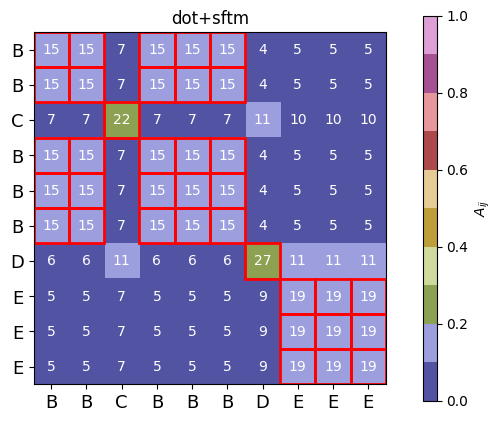

In [3]:
def highlight_cell(x,y,color,ax):
    # Given a coordinate (x,y), highlight the corresponding cell using a colored frame in the ac
    # after having called imshow already
    rect = plt.Rectangle((x-.5, y-.5), 1,1, fill=False,color=color,lw=2)
    ax.add_patch(rect)
    return rect

def adapt_to(x,ax,data,has_BOS=False):
    for i, x_i in enumerate(x):
        for j, x_j in enumerate(x):
            if x_i == x_j:
                highlight_cell(i,j, color='red',ax=ax)
    for k in range(data.shape[0]):
            for j in range(data.shape[1]):
                ax.text(j, k, f'{int(np.round(data[k, j]*100))}', ha='center', va='center', color='white')
    if has_BOS:
        rect = plt.Rectangle((0-.5, 0-.5), data.shape[0],1, fill=False,color='cyan',lw=3)
        ax.add_patch(rect)
        rect = plt.Rectangle((0-.5, 0-.5), 1,data.shape[1], fill=False,color='cyan',lw=3)
        ax.add_patch(rect)
        
    alpha = 'ABCDEFGHIJKLMNOPQRSTUVW'
    alpha = alpha + (config['T']-len(alpha))*' ' + '$'
    ax.set_xticks(np.arange(len(x)), [alpha[a] for a in x],fontsize=13)
    ax.set_yticks(np.arange(len(x)), [alpha[a] for a in x],fontsize=13)

fig, axes = plt.subplots(1, 2, figsize=(5.2, 5),width_ratios=[5,0.2])

vmax = 1.0
cmap = ATTENTION_SCORE_CMAP

x_orig = [1,1,2,1,1,1,3,4,4,4]

# LINEAR
ax = axes[0]
import matplotlib as mpl

# Configure Matplotlib to use LaTeX with texttt in the preamble
mpl.rcParams['text.usetex'] = False
ax.set_title(r'dot+sftm')
X = torch.tensor(x_orig).unsqueeze(0).to(device)
model(X)
data = model.attn_probs.detach().cpu().numpy()[0]
im = ax.imshow(data, cmap=cmap,vmin=0.0,vmax=vmax)
adapt_to(x_orig,ax,data)

fig.colorbar(im, cax=axes[-1], label=r'$A_{ij}$')

plt.savefig(figure_dir / 'dot_sftm_matrix.pdf', bbox_inches='tight')

/tmp/ipykernel_3825477/639376798.py:46: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axes[-1].scatter([],[],c=color, label=f"${i}$")


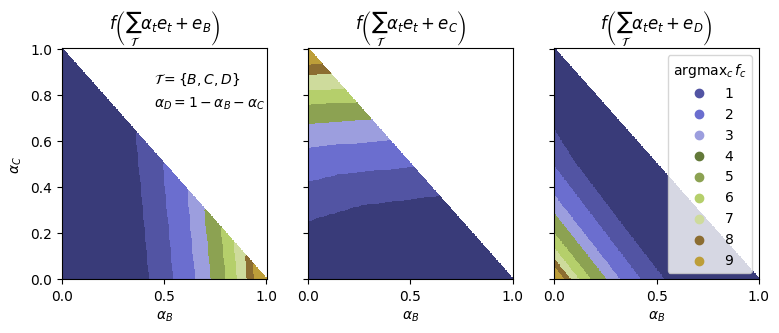

In [4]:
n_points = 300
x = np.linspace(0,1.0,n_points)
y = np.linspace(0,1.0,n_points)
xx, yy = np.meshgrid(x,y)
xx = xx.flatten()
yy = yy.flatten()
mask = xx+yy <= 1
#xx = xx[mask]
#yy = yy[mask]
grid = np.stack([xx,yy,1-xx-yy], axis=1) 
# todo: changed
xx = grid[:,0] 
yy = grid[:,1] 
zz = grid[:,2] 
# compute the sum of the embeddings for each point in the grid
grid = torch.tensor(grid, dtype=torch.float32)
embeddings = (grid[:,0] *all_embbedings[0].reshape(-1,1)
              + grid[:,1] * all_embbedings[1].reshape(-1,1) 
             + grid[:,2] * all_embbedings[2].reshape(-1,1) 
            ) # to permute randomly [torch.randperm(64)]
k=3
max_items_per_row = min(7,k)
fig, axes = plt.subplots(k//max_items_per_row,max_items_per_row, figsize=(3*max_items_per_row,3*k//max_items_per_row),sharex=True, sharey=True)
axes=axes.flatten()
token_names = ['B','C','D']
# get the tab10 colors in a list
colors = plt.get_cmap('tab20b').colors
from matplotlib.colors import ListedColormap
cmap = ListedColormap(colors[:config['seq_len']])
for i in range(k):
    enc_output = all_embbedings[i]
    enc_output = enc_output.repeat(len(xx),1)
    c = model.get_output(embeddings.T.to(device), enc_output.to(device)).argmax(dim=1).cpu().detach().numpy()
    #im = axes[i].scatter(xx,yy,c=[colors[v] for v in c])
    axes[i].pcolor(x, y, np.ma.masked_where(~mask.reshape(n_points,n_points),c.reshape(n_points,n_points)), cmap=cmap)
    axes[i].set_xlabel(f'$\\alpha_{token_names[0]}$')
    
    # add text that says hi in the top right corner
    if i == 0:
        axes[i].text(0.45, 0.85, f"$\\mathcal{{T}} = \\{{ {','.join(token_names)} \\}}$")
        axes[i].text(0.45, 0.75, f"$\\alpha_{token_names[2]} = 1 - \\alpha_{token_names[0]} - \\alpha_{token_names[1]}$")
    axes[i].set_title(f"$f\left(\sum_{{\mathcal{{T}}}}\\alpha_t e_t + e_{token_names[i]}\\right)$")
for i, color in enumerate(colors[:config['seq_len']]):
    if i ==0:
        continue
    axes[-1].scatter([],[],c=color, label=f"${i}$")
axes[0].set_ylabel(f'$\\alpha_{token_names[1]}$')
plt.legend(title=r'$\operatorname{argmax}_c f_c$')
plt.savefig(figure_dir / 'FF_dot_sftm_model.png', bbox_inches='tight')